In [2]:
library(data.table)
library(mixOmics)
library(raster)
library(pracma)
library(ggpubr)

In [3]:
#Schizophrenia EWAS results for sites previously identified as associated with tobacco smoking
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")

In [4]:
sample_id_phase1 <- read.csv("~/Documents/data/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_phase2 <- read.csv("~/Documents/data/E-GEOD-84727.sdrf.txt",sep = "\t")

In [5]:
phase1 <- fread("~/Documents/data/GSE80417_normalizedBetas.csv", header = T)
phase2 <- fread("~/Documents/data/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(phase1$V1,phase2$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)


phase1 <- subset(phase1, V1 %in% common_probes)
phase2 <- subset(phase2, V1 %in% common_probes)

In [6]:
probe_set=4

In [7]:
if(probe_set==4){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv",stringsAsFactors = F)
    #top_variable_probes <- top_variable_probes[1:500,]
    probe_loc <- read.csv("~/Documents/research/mccs_cancer_cohort/ALL_CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",header = T,stringsAsFactors = F,sep = ",")
    probe_loc <- probe_loc[order(probe_loc$chr, probe_loc$pos),]
    probe_loc <- probe_loc[!duplicated(probe_loc$CG),]
    probe_loc <- probe_loc[!duplicated(probe_loc$cluster_id),]
    
    phase1 <- subset(phase1, V1 %in% unique(c(probe_loc$CG,top_variable_probes$V1)))
    phase2 <- subset(phase2, V1 %in% unique(c(probe_loc$CG,top_variable_probes$V1)))
}

In [8]:
if(probe_set==3){
    top_variable_probes <- read.csv("./highest_variable_probes_in_phase1.csv")
    phase1 <- subset(phase1, V1 %in% top_variable_probes$V1)
    phase2 <- subset(phase2, V1 %in% top_variable_probes$V1)
}

In [9]:
if(probe_set == 2){
    table_s3_hannon_et_al_2016 <- read.csv("~/Documents/data/schizo_data_table_s3.csv",header = T)
    phase1 <- subset(phase1, V1 %in% table_s3_hannon_et_al_2016$probe_id)
    phase2 <- subset(phase2, V1 %in% table_s3_hannon_et_al_2016$probe_id)
}


In [10]:
if(probe_set==1){
    probe_loc <- read.csv("~/Documents/research/mccs_cancer_cohort/CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",header = T,stringsAsFactors = F,sep = ",")
    probe_loc <- probe_loc[order(probe_loc$chr, probe_loc$pos),]
    probe_loc <- probe_loc[!duplicated(probe_loc$CG),]

    average_corsiv_methylation <- function(DF){

        temp_clinical <- DF[ , !grepl( "cg[0-9]" , names( DF ) ) ]
        probe_data <-DF[ , grepl( "cg[0-9]" , names( DF ) )]

        avg_prob_df <- data.frame(matrix(ncol = 0, nrow = dim(probe_data)[1]))

        for(probe_cluster_id in unique(probe_loc$cluster_id)){
            #print(probe_cluster_id)
            #probe_cluster_id <- "single14"
            probs_temp <- probe_loc[probe_loc$cluster_id==probe_cluster_id,]$CG
            if(length(intersect(colnames(probe_data),probs_temp)) > 0){
                data_prob_cluster <- probe_data[intersect(colnames(probe_data),probs_temp)]
                avg_prob_df[[probs_temp[1]]] <- apply(data_prob_cluster, 1,mean)
            }
        }
        return(cbind(temp_clinical,avg_prob_df))
    }
    
    phase1 <- subset(phase1, V1 %in% probe_loc$CG)
    phase2 <- subset(phase2, V1 %in% probe_loc$CG)
}


In [11]:
colnames_phase1 <- phase1$V1
phase1$V1 <- NULL
phase1_t <- data.frame(t(phase1))
colnames(phase1_t) <- colnames_phase1
phase1_t$sample.id <- rownames(phase1_t)
rownames(phase1_t) <- NULL

In [12]:
colnames_phase2 <- phase2$V1
phase2$V1 <- NULL
phase2_t <- data.frame(t(phase2))
colnames(phase2_t) <- colnames_phase2
phase2_t$sample.id <- rownames(phase2_t)
rownames(phase2_t) <- NULL

In [13]:
train <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
test <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))


In [14]:
if(probe_set==1){
    train <- average_corsiv_methylation(train)
    test <- average_corsiv_methylation(test)
    }

In [15]:
train$id <- NULL
train$gender <- NULL
train$age <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

In [16]:
test$id  <- NULL
test$sample_title <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))

In [17]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 2,keepX=c(200,200))

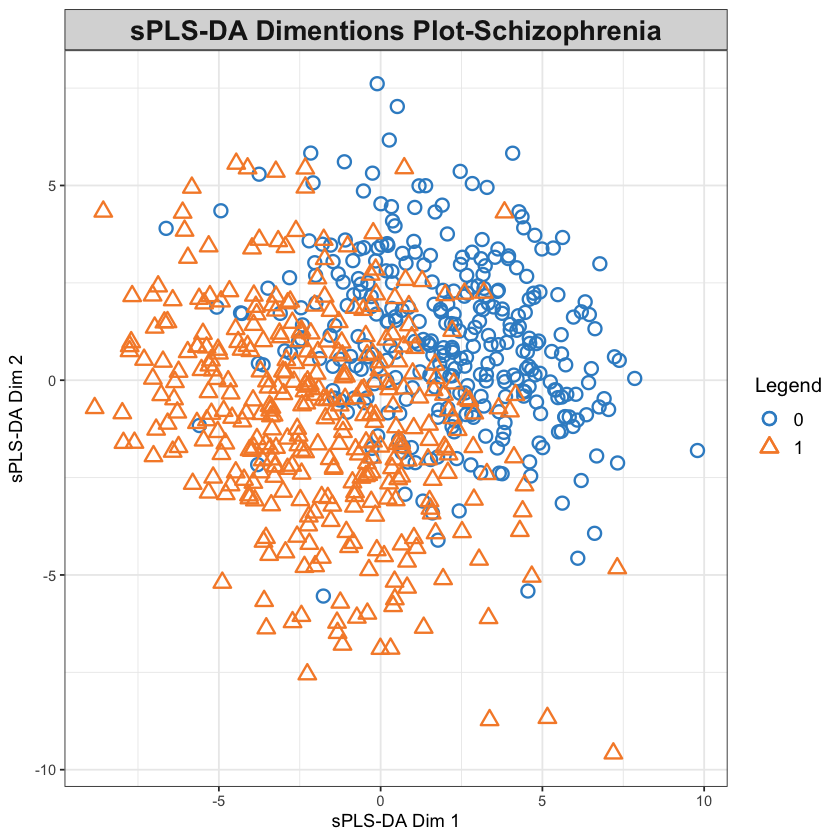

In [18]:
v <- plotIndiv(splsda_output_beta, ind.names = FALSE, legend=TRUE,
               ellipse = FALSE, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"),
               X.label = 'sPLS-DA Dim 1', Y.label = 'sPLS-DA Dim 2',graphics.off=T)

[1] 2.118681
[1] -2.201088


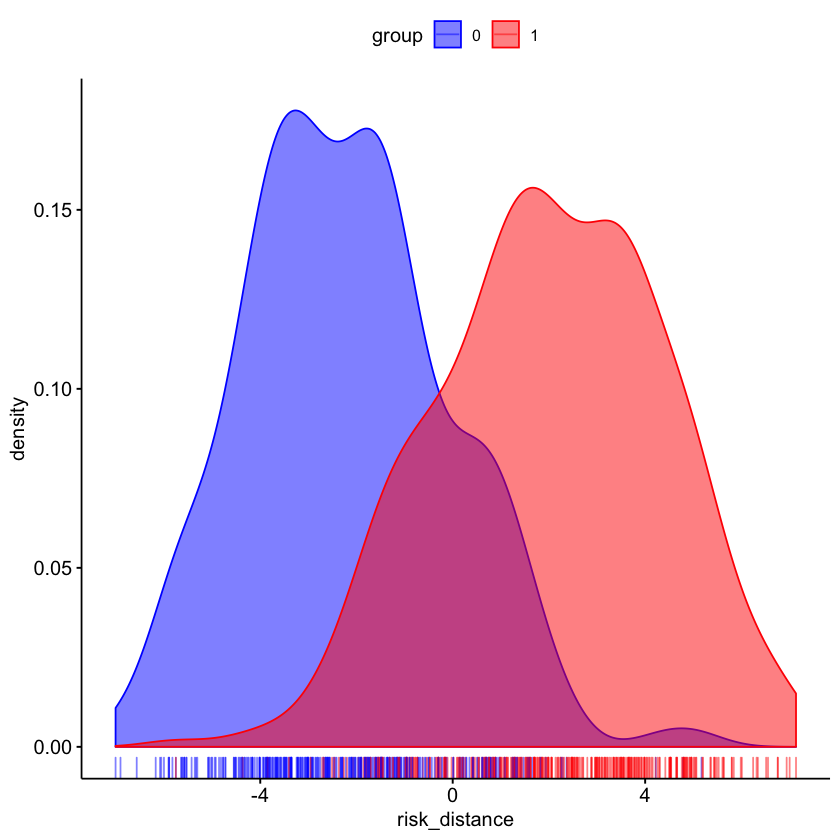

In [19]:
plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
risk_distance <- function(cancer_sample){
    X <- as.numeric(cancer_sample[1])
    Y <- as.numeric(cancer_sample[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) + deg2rad(135)))# - for MBCN + for BC
}
plsdaDF$risk_distance <- 1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]
cutoff <- 2*sd(plot.data[plot.data$group==0,]$risk_distance)
ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))
stdev_controls <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_controls <- mean(plot.data[plot.data$group==0,]$risk_distance)
print(stdev_controls)
print(mean_controls)

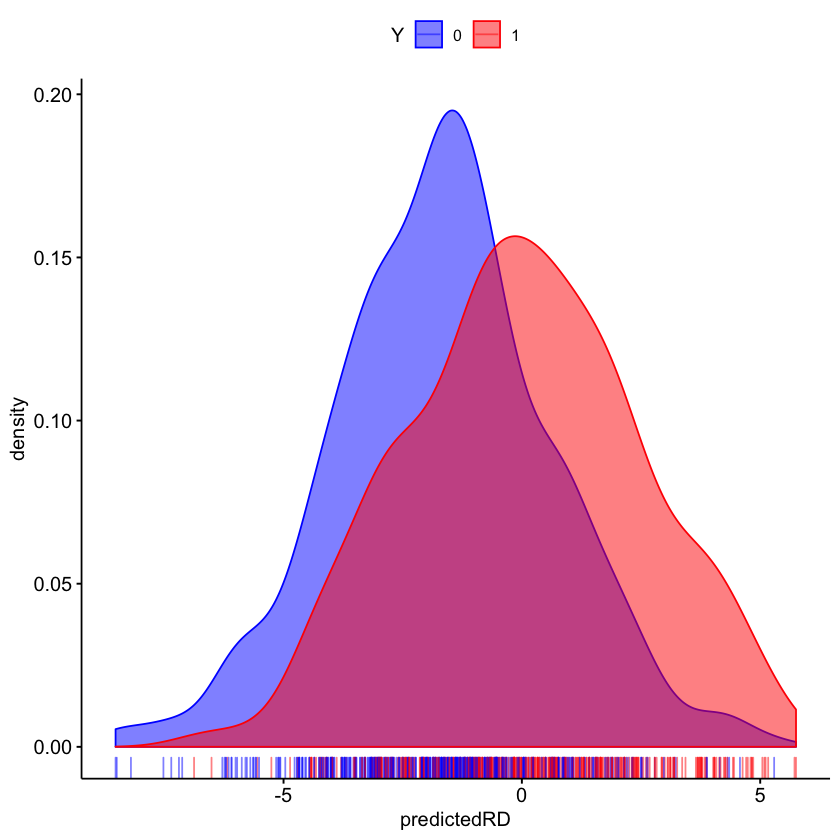

In [20]:
########### PREDICTION ######
##########################################################################
Y <- test$status
test$status <- NULL


test.predict <- predict(splsda_output_beta, test)

predicted_RD <- data.frame(1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

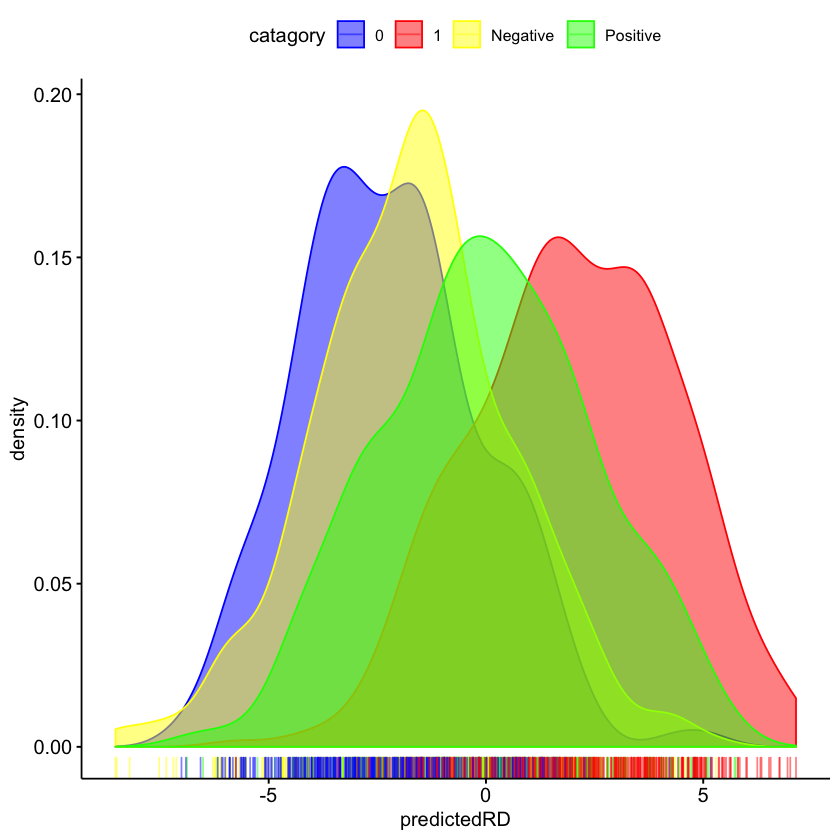

In [21]:
predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","yellow","green"))

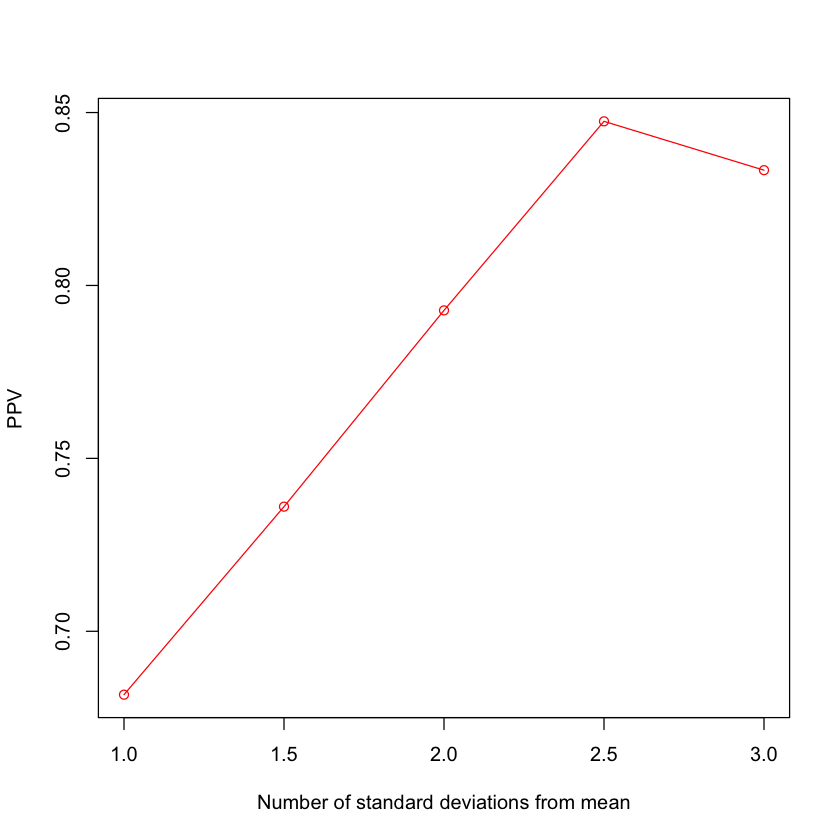

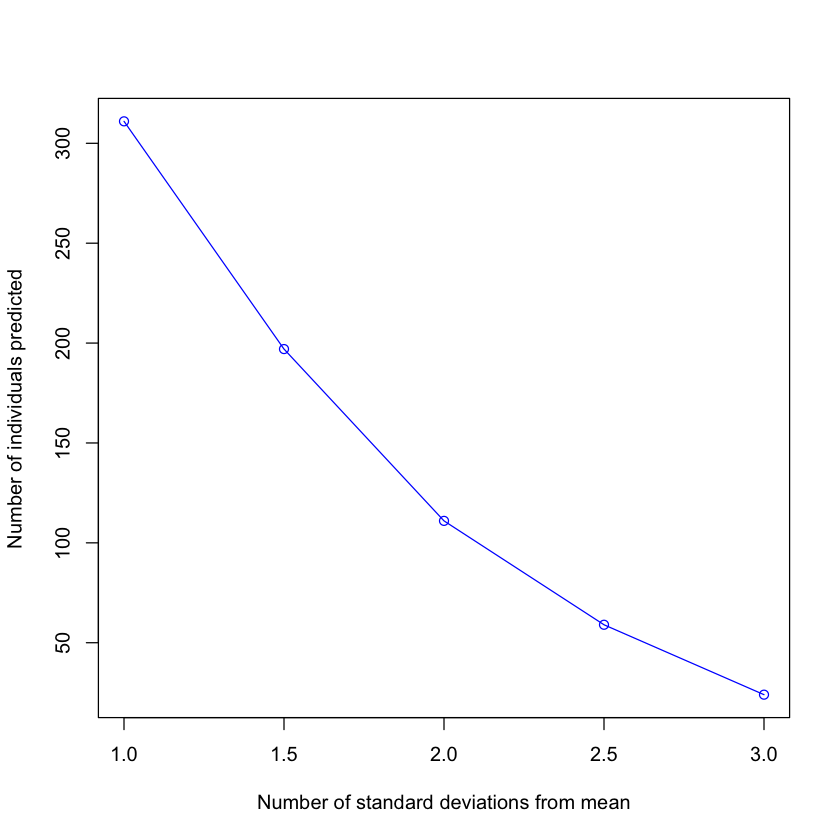

In [22]:
#################################################
PPV <-c()
num_of_predicted_ind <- c()
#stdev <- sd(plot.data[plot.data$catagory==0,]$risk_distance)#increase n
#mean_PRD <- mean(plot.data[plot.data$catagory==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev_controls
    cutoff <- mean_controls + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}

plot(x=seq(1,3,0.5),y=PPV,type="o",col="red",xlab="Number of standard deviations from mean")
plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")

In [23]:
num_of_predicted_ind

[1] 311 197 111  59  24

In [24]:
PPV

[1] 0.6816720 0.7360406 0.7927928 0.8474576 0.8333333

In [25]:
varComp1 <- selectVar(splsda_output_beta,comp = 1)
varComp2 <- selectVar(splsda_output_beta,comp = 2)

selected_C1 <- data.frame(varComp1$value)
selected_C2 <- data.frame(varComp2$value)

selected_C1$pairs <- row.names(selected_C1)
selected_C2$pairs <- row.names(selected_C2)

#model_selected_pairs <- unique(rownames(selected_C1),rownames(selected_C2))


In [26]:
varible_DF <- merge(selected_C1,selected_C2,by = "pairs")
varible_DF$value.var.x <- varible_DF$value.var.x**2
varible_DF$value.var.y <- varible_DF$value.var.y**2

In [27]:
varible_DF$lengh <- sqrt(varible_DF$value.var.x + varible_DF$value.var.y)

In [28]:
anno <- read.csv("./HM450k_probe_gene_table.csv",header = T)

In [29]:
var_imp <- merge(varible_DF,anno,by.x ="pairs",by.y="probe_id" )

In [30]:
var_imp <- var_imp[order(var_imp$lengh,decreasing = T),]
#write.csv(var_imp,file="./Ranked_list_most_variable_probes_with_CoRSIV_probes.csv")

In [31]:
intersect(var_imp$pairs,
          probe_loc$CG)
          
intersect(var_imp$pairs,top_variable_probes$V1)

[1] "cg08493063" "cg27656459" "cg18463607" "cg00774102" "cg24323958"
 [6] "cg07377178" "cg25325723" "cg23137881" "cg09991306" "cg04960065"
[11] "cg03174521" "cg09854184" "cg04304802" "cg04118119" "cg19268947"
[16] "cg27639613" "cg23643542" "cg12138330" "cg04993605" "cg03411742"
[21] "cg17545182" "cg25048816" "cg18855195" "cg17697873" "cg17178900"

[1] "cg09935388" "cg21188533" "cg12803068" "cg23256579" "cg22138735"
[6] "cg24503407" "cg07167872" "cg17178900"